Here we will demonstrate how to export a trained model and load it outside of the datajoint pipeline.

# Export trained model

First, let's load and save the model state dict we want to export.

In [1]:
from foundation.fnn.model import ModelCheckpoint
import torch
key = dict(
    data_id="e39f2b0628b9d8da2177fb7eb7a1073a",
    network_id="89e60439a60a69b534673310f5948108",
    instance_id="3b38faa5338da5d7cdccc283942b22c6",
)
state_dict = (ModelCheckpoint & key).parameters("cuda")
torch.save(state_dict, "/tmp/model.pt")

Connecting zhuokun@at-database.ad.bcm.edu:3306


# Load trained model

Second, we will import the corresponding model building function in the fnn package and load the exported `state_dict`. For the above `network_id`, the model building function has been implemented as `fnn.model_loader.cvtlstm_model`.

For every `network_id`, `data_id` pair, a separate model building function and data preprocessing function will need to be extracted from the foundation pipeline and implemented in the fnn package for datajoint-free model loading.

In [ ]:
from fnn.model_loader import cvtlstm
state_dict = torch.load("/tmp/model.pt")
model = cvtlstm.model(state_dict=state_dict, device="cuda", freeze=True)

# Generate model responses

Let's then generate some responses from the loaded model.

We will load the stimulus from the foundation pipeline as example stimuli but they can be any gray scale video defined by frames and frame times.

In [30]:
from foundation.stimulus import video as foundation_video
import numpy as np

stim_key = {
    'data_id': 'e39f2b0628b9d8da2177fb7eb7a1073a',
    'network_id': '89e60439a60a69b534673310f5948108',
    'instance_id': '3b38faa5338da5d7cdccc283942b22c6',
    'trial_filterset_id': 'd00bbb175d63398818ca652391c18856',
    'videoset_id': 'acb04adeca72c460a2c5849c22630b14',
    'correlation_id': '9d7c0855cf673c141729b0af5844857b',
    'burnin': 10,
    'perspective': 0,
    'modulation': 0
}

# load videos as gray-scale frames of shape (height, width, 1)
# videos
v = (foundation_video.Video & (foundation_video.VideoSet & stim_key).members).fetch(limit=1)
frames = [np.array(f) for f in (foundation_video.Video & v).link.compute.video.frames]
frames = np.stack(frames, axis=0)  # (frame, height, width)
times = np.arange(frames.shape[0]) / 30  # (frame,)

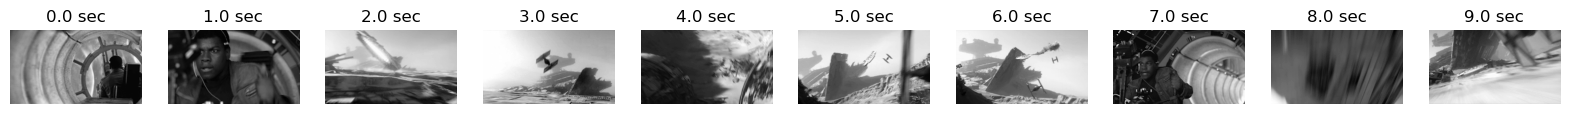

In [47]:
# plot some example frames
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 2))
for i, f in enumerate(range(0, 299, 30)):
    plt.subplot(1, 10, i + 1)
    plt.imshow(frames[f, :, :], cmap="gray")
    plt.title(f'{times[f]} sec')
    plt.axis("off")
plt.show()

Let's generate responses.

In [44]:
processed_f = cvtlstm.preprocess(frames, times)
response = np.array(list(model.generate_response(processed_f)))
response.shape

Video Frames:   0%|          | 0/300 [00:00<?, ?it/s]

Video Frames: 100%|██████████| 300/300 [00:02<00:00, 132.54it/s]


(300, 7493)